In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
def plot_multiple_images(images,n_cols=None):
    '''Sahte resimlerin gösterilmesi'''
    display.clear_output(wait=False)
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] ==1:
        images = np.squeeze(images,axis=1)

    plt.figure(figsize=(n_cols,n_rows))
    for index,image in enumerate(images):
        plt.subplot(n_rows,n_cols,index + 1)
        plt.imshow(image,cmap="binary")

        plt.axis("off")

In [3]:
(X_train, _), _ = keras.datasets.mnist.load_data()

X_train = X_train.astype(np.float32) / 255.0

BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE,drop_remainder=True).prefetch(1)

In [4]:
#gürültü girdisinin boyutunu belirleme
random_normal_dimensions = 32
#üretici için model oluşturma
generator = keras.models.Sequential([
    keras.layers.Dense(64,activation="selu",input_shape=[random_normal_dimensions]),
    keras.layers.Dense(128,activation="selu"),
    keras.layers.Dense(28*28,activation="sigmoid"),
    keras.layers.Reshape([28,28])
])

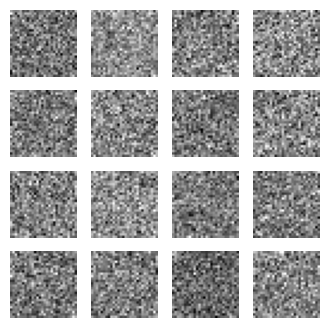

In [5]:
#bir batch gürültü verisi üretme (batch size = 16)
test_noise = tf.random.normal([16,random_normal_dimensions])

#eğitilmemiş üretici ağı batch ile beslenmekte
test_image = generator(test_noise)

#çıktıları görselleştirme
plot_multiple_images(test_image,n_cols=4)

In [6]:
#Ayırt edici için modelin oluşturulması
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(128,activation="selu"),
    keras.layers.Dense(64,activation="selu"),
    keras.layers.Dense(1,activation="sigmoid")
])

In [7]:
#gan modelinin tanımlanması
gan = keras.models.Sequential([generator,discriminator])
discriminator.compile(loss="binary_crossentropy",
                      optimizer = "rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy",optimizer="rmsprop")

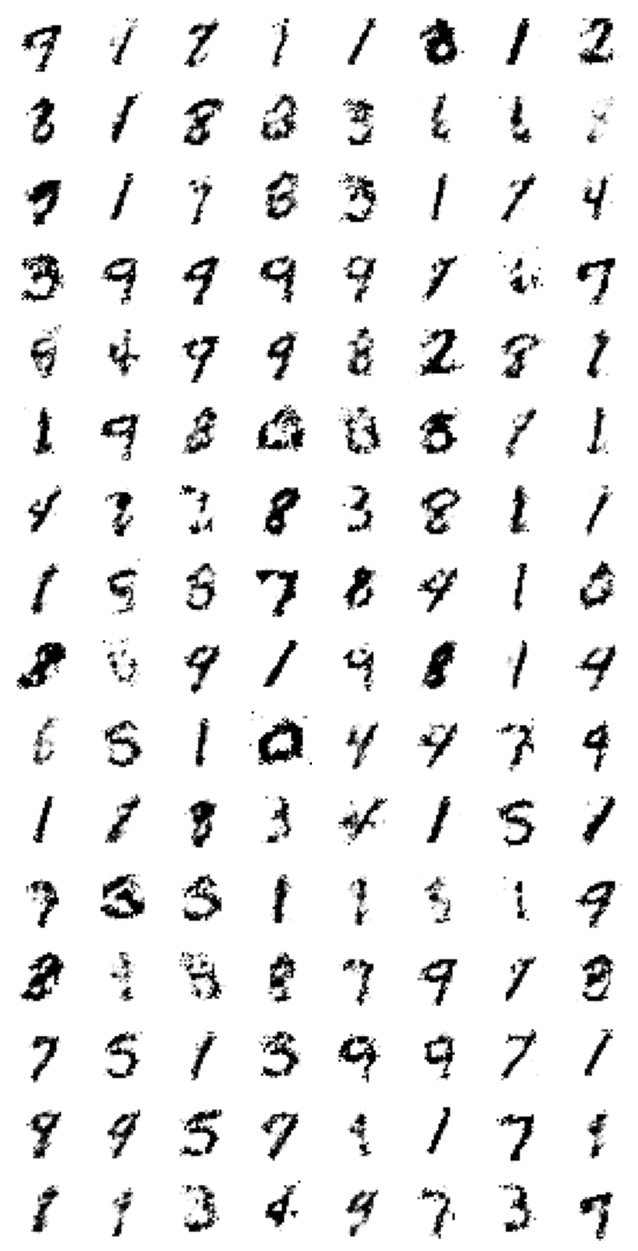

In [9]:
#gan modelinin eğitilmesi
def train_gan(gan,dataset,random_normal_dimensions,n_epochs = 50):
    generator,discriminator = gan.layers

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:
            batch_size = real_images.shape[0]

            #1. aşama ayırt edicinin eğitilmesi
            #rastgele gürültü oluşturma
            noise = tf.random.normal(shape = [batch_size, random_normal_dimensions])

            #gürültülerden sahte görüntüler üretme
            fake_images = generator(noise)

            #sahte görüntüleri gerçek olanlarla birleştirip bir liste oluşturma

            mixed_images = tf.concat([fake_images,real_images],axis=0)
            #ayırt edici için etiket oluşturma
            #sahte görüntüler için : 0
            #gerçek görüntüler için : 1
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]]* batch_size)

            # ayırt ediciyi eğitilebilir duruma getirme
            discriminator.trainable = True

            #ayırt edicinin 'train_on_batch' komutu ile karışık görüntüler ve etiketler ile eğitilmesi
            discriminator.train_on_batch(mixed_images,discriminator_labels)

            #2.aşama üreticinin eğitilmesi
            #gan modelini beslemek için bir parça gürültü girişi verilmesi
            noise = tf.random.normal(shape = [batch_size,random_normal_dimensions])

            #oluşturulan görüntülerin gerçek olarak etiketlenmesi 
            generator_labels = tf.constant([[1.]] * batch_size)

            #ayırt edicinin eğitilmesini durdurma
            discriminator.trainable = False

            #tümünün etiketleri gerçek olarak ayarlanmış veriler ile GAN modelinin eğitilmesi
            gan.train_on_batch(noise,generator_labels)

    #ayırt ediciyi eğitmek için kullanılan üretilmiş sahte görüntülerin çizdirilmesi
    plot_multiple_images(fake_images,8)
    plt.show()

train_gan(gan,dataset,random_normal_dimensions,n_epochs=20)